In [1]:
import matplotlib.pyplot as plt # Está diseñada para crear gráficos y visualizaciones interactivas de datos, por ejemplo, para trazar las curvas de aprendizaje y evaluar el proceso de entrenamiento.
import numpy as np # Se utiliza para crear arreglos multidimensionales y realizar operaciones matemáticas, lógicas y de álgebra lineal, además de la generación de números aleatorios.
import os # Permite trabajar con archivos y directorios, gestionar rutas, y realizar operaciones relacionadas con el sistema.
import tensorflow as tf # Librería desarrollada por Google, es de las más utilizadas para diseñar, entrenar, validar y probar el desarrollo de una red neuronal.
from tensorflow.keras.applications import MobileNetV2 # Importa el modelo preentrenado MobileNetV2.
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization # Importa capas comunes en una red neuronal.
from tensorflow.keras.models import Model # Importa la base para crear modelos personalizados en TensorFlow.
from tensorflow.keras.optimizers import Adam # Importa el optimizador Adam.
from tensorflow.keras.callbacks import EarlyStopping # Importa el regulizador EarlyStopping.
from tensorflow.keras.utils import load_img, img_to_array # Carga y convierte imágenes en arreglos para su uso en redes neuronales.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Se utiliza para gráficar en una matriz una comparación entre los valores reales y predichos.
import cv2 # Procesa imágenes y videos, útil para tareas de visión por computadora.

In [2]:
tf.random.set_seed(21) # Se fija una semilla para obtener respuestas similares al trabajar con el entrenamiento de redes neuronales.
np.random.seed(21) # Se fija una semilla para obtener respuestas similares al trabajar con números aleatorios.

In [3]:
!unzip '/content/cats_and_dogs_filtered.zip' # Se abre la carpeta zip.

Archive:  /content/cats_and_dogs_filtered.zip
replace cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: cats_and_dogs_filtered/vectorize.py  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2120.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2119.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2118.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2117.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2116.jpg  
  inflating: c

In [4]:
train_dir = '/content/cats_and_dogs_filtered/train' # Se establece el directorio de entrenamiento.
validation_dir = '/content/cats_and_dogs_filtered/validation' # Se establece el directorio de validación.

In [5]:
BATCH_SIZE = 32 # Se establece el directorio de entrenamiento.
IMG_SIZE = (224, 224) # Se establece el tamaño de imagen 224x224 píxeles.

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True, # Baraja aleatoriamente las imágenes para mezclar los datos de entrenamiento.
                                                            batch_size=BATCH_SIZE,  # Divide las imágenes en lotes de tamaño.
                                                            image_size=IMG_SIZE) # Redimensiona automáticamente todas las imágenes a un tamaño de 224x224 píxeles.

Found 2000 files belonging to 2 classes.


In [6]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True, # Baraja aleatoriamente las imágenes para mezclar los datos de entrenamiento.
                                                                 batch_size=BATCH_SIZE, # Divide las imágenes en lotes de tamaño.
                                                                 image_size=IMG_SIZE) # Redimensiona automáticamente todas las imágenes a un tamaño de 224x224 píxeles.

Found 1000 files belonging to 2 classes.


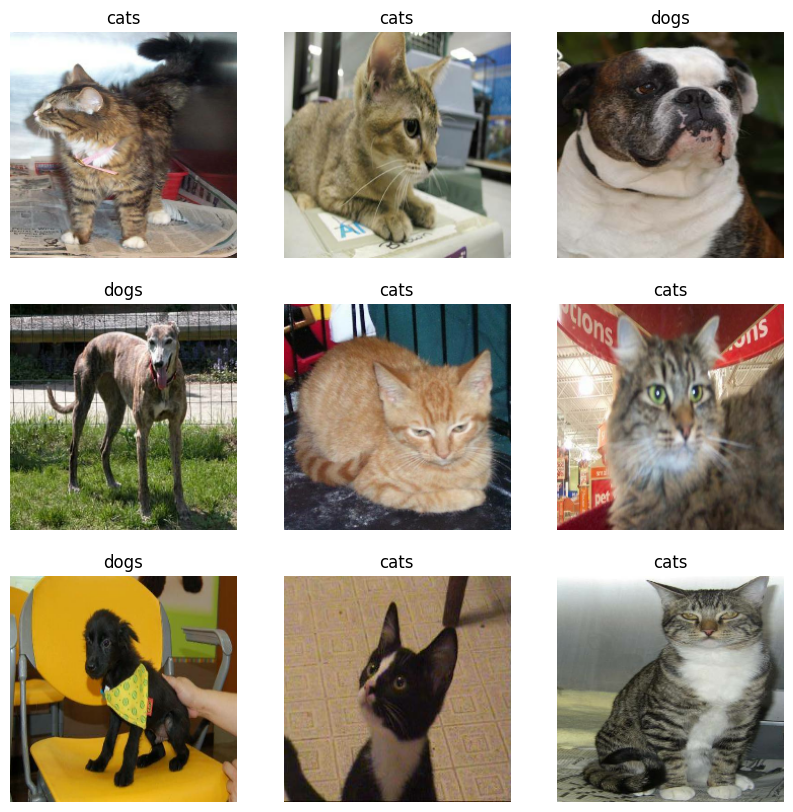

In [7]:
class_names = train_dataset.class_names # Extrae los nombres de las clases del conjunto de datos de entrenamiento.

plt.figure(figsize=(10, 10)) # Se muestran las primeras 9 imágenes del conjunto de entrenamiento.
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

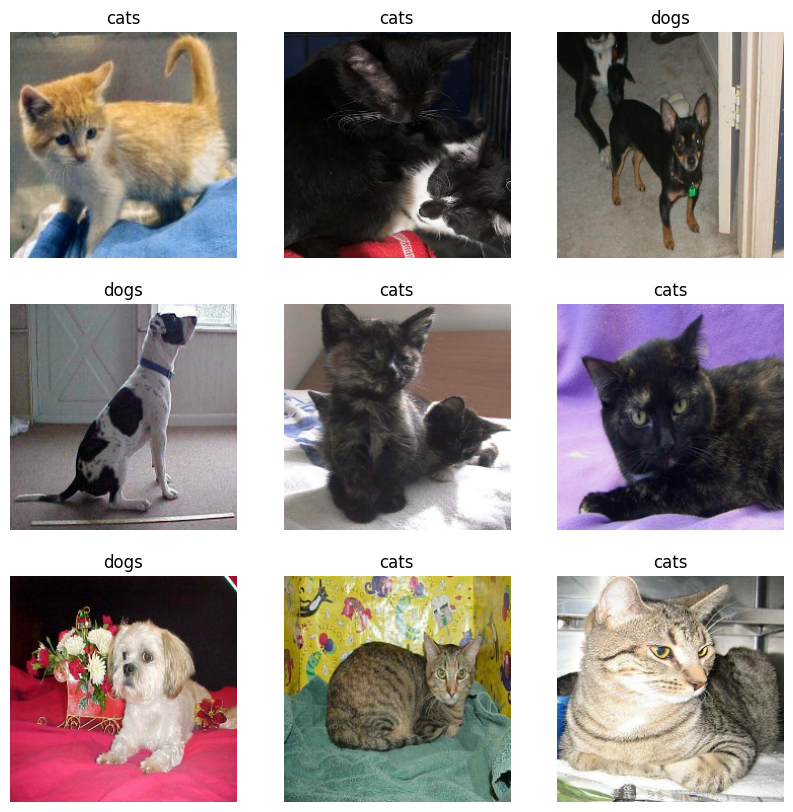

In [8]:
class_names = validation_dataset.class_names # Extrae los nombres de las clases del conjunto de datos de validación.

plt.figure(figsize=(10, 10)) # Se muestran las primeras 9 imágenes del conjunto de validación.
for images, labels in validation_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
print(class_names) # Se imprimen los nombres de las clases, con lo que cats = 0 y dogs = 1

['cats', 'dogs']


In [10]:
val_batches = tf.data.experimental.cardinality(validation_dataset) # Obtiene el número total de lotes (batches) en el conjunto de datos de validación (validation_dataset).
test_dataset = validation_dataset.take(val_batches // 5) # Toma el 20% (1/5) de esos batches para el conjunto de prueba.
validation_dataset = validation_dataset.skip(val_batches // 5) # Toma el restante 80% (4/5) de esos batches para el conjunto de validación.

In [11]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset)) # 26x32 = 832 imágenes.
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset)) # 6x32 = 192 imágenes.

Number of validation batches: 26
Number of test batches: 6


In [12]:
# Operaciones como dividir por 255 (x / 255.0) requieren que los datos sean de tipo flotante.
train_dataset = train_dataset.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))  # Se normalizan los datos de entrenamiento en un rango de [0 1].
validation_dataset = validation_dataset.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)) # Se normalizan los datos de validación en un rango de [0 1].
test_dataset = test_dataset.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)) # Se normalizan los datos de prueba en un rango de [0 1].

In [13]:
IMG_SHAPE = IMG_SIZE + (3,)  # Añadir la dimensión de canales RGB.

# Se carga el modelo MobileNetV2 preentrenado con pesos de ImageNet.
base_model = MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

# Descongelar las capas del modelo base (se entrenan).
base_model.trainable = True

In [14]:
# Se muestra el número de capas de capas en el modelo preentrenado MobileMetV2.
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [28]:
# Se realizará un ajuste fino a partir de esta capa.
fine_tune_at = 75

# Se realizá un layer-freezing antes de la capa seleccionada
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [29]:
# Crear la parte superior personalizada del modelo.
x = base_model.output # La entrada de nuestro modelo es la salida del modelo preentrenado.
x = Flatten()(x)  # Aplana las características extraídas.
output = Dense(1, activation='sigmoid')(x)  # Activación sigmoide para clasificación binaria.

# Modelo final
model = Model(inputs=base_model.input, outputs=output)

In [30]:
model.compile(optimizer=Adam(learning_rate=0.00001), # Se establece el optimizador Adam, con un learning rate igual al predeterminado entre 100.
              loss='binary_crossentropy', # Se establece la función de pérdida.
              metrics=['accuracy'])

In [31]:
early_stopping = EarlyStopping( # Se establece el regulador EarlyStopping.
    patience=3,
    monitor='val_loss',
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=15,
    callbacks=[early_stopping] # Se añade el EarlyStopping como callback para evitar periodos largos de entrenamiento.
)

Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.7352 - loss: 0.5750 - val_accuracy: 0.9394 - val_loss: 0.1716
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.9629 - loss: 0.1208 - val_accuracy: 0.9455 - val_loss: 0.1388
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.9759 - loss: 0.0822 - val_accuracy: 0.9579 - val_loss: 0.1123
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.9856 - loss: 0.0479 - val_accuracy: 0.9629 - val_loss: 0.1044
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9897 - loss: 0.0391 - val_accuracy: 0.9691 - val_loss: 0.0860
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.9957 - loss: 0.0269 - val_accuracy: 0.9678 - val_loss: 0.0919
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9907 - loss: 0.0282 - val_accuracy: 0.9715 - val_loss: 0.0824
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.9989 - loss: 0.0179 - val_accuracy: 0.9715 -

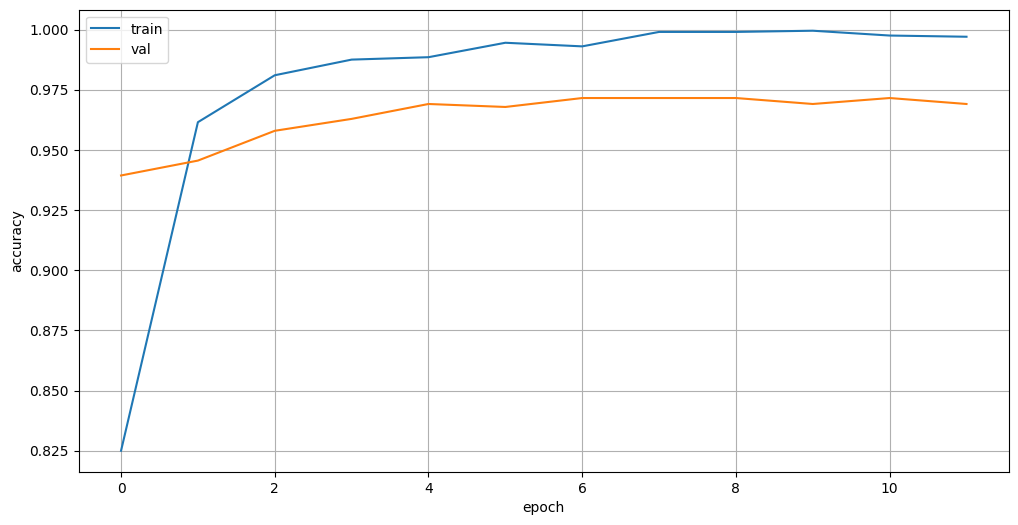

In [32]:
# Plot validation and testing accuracy
plt.figure(figsize=(12,6)) # Se establece el tamaño de la gráfica.
plt.plot(history.history['accuracy']) # Se gráfica la exactitud del modelo a través de las épocas.
plt.plot(history.history['val_accuracy']) # Se gráfica la exactitud del modelo con los datos de validación del entrenamiento a través de las épocas.
plt.xlabel('epoch') # El eje x corresponde a las épocas.
plt.ylabel('accuracy') # El eje y corresponde a las exactitud.
plt.legend(['train', 'val']) # Se añade una leyenda para distinguir entre entrenamiento y validación.
plt.grid(); # Se añade una cuadrícula a la gráfica para mejorar la legibilidad.

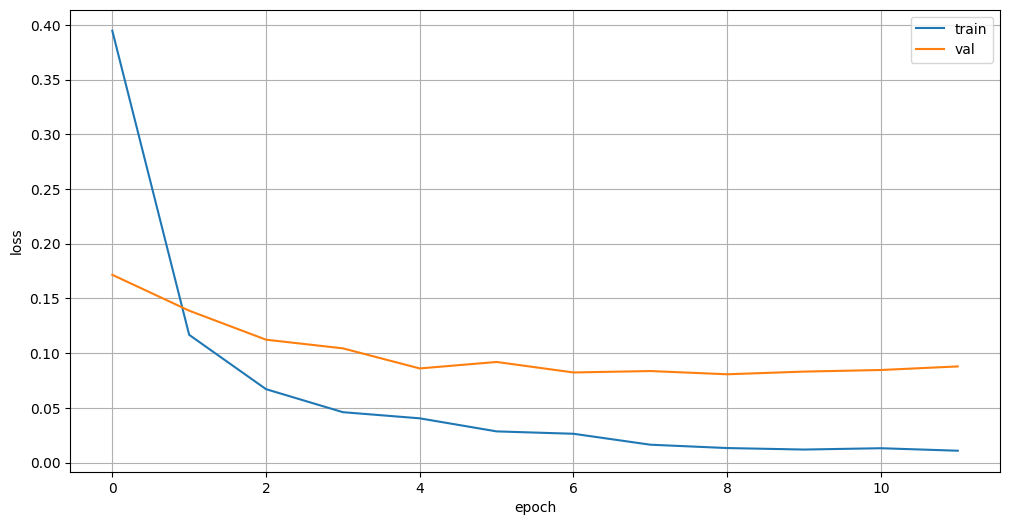

In [33]:
# Plot validation and testing loss
plt.figure(figsize=(12,6)) # Se establece el tamaño de la gráfica.
plt.plot(history.history['loss']) # Se gráfica la pérdida del conjunto de entrenamiento a lo largo de las épocas.
plt.plot(history.history['val_loss']) # Se gráfica la pérdida con los datos de validación del entrenamiento a lo largo de las épocas.
plt.xlabel('epoch') # El eje x corresponde a las épocas.
plt.ylabel('loss') # El eje y corresponde a la pérdida.
plt.legend(['train', 'val'])  # Se añade una leyenda para distinguir entre entrenamiento y validación.
plt.grid(); # Se añade una cuadrícula a la gráfica para mejorar la legibilidad.

In [34]:
model.summary() # Muestra un resumen del modelo.

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 5,695,941 (21.73 MB)

 Trainable params: 1,687,617 (6.44 MB)

 Non-trainable params: 633,088 (2.42 MB)

 Optimizer params: 3,375,236 (12.88 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


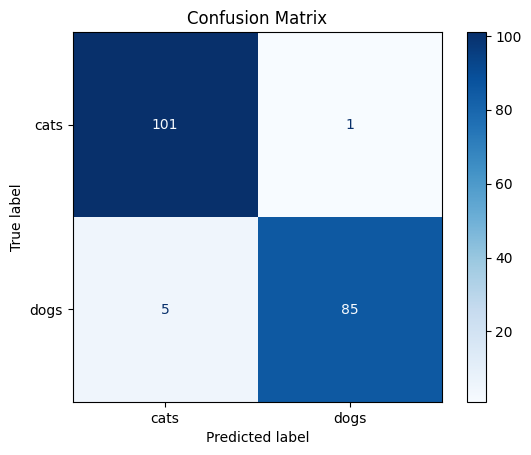

In [35]:
# Obtener las predicciones del modelo en el conjunto de prueba
y_true = []
y_pred = []

for images, labels in test_dataset:
    y_true.extend(labels.numpy())  # Verdaderas etiquetas
    predictions = model.predict(images)  # Predicciones
    y_pred.extend(np.round(predictions).flatten())  # Redondear a 0 o 1

# Crear matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)

# Mostrar la matriz de confusión
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

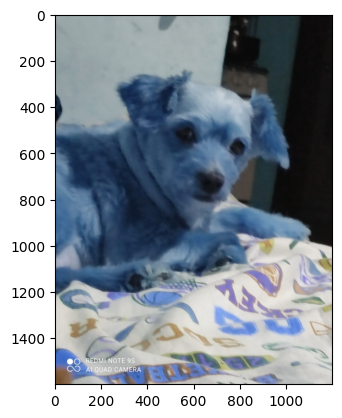

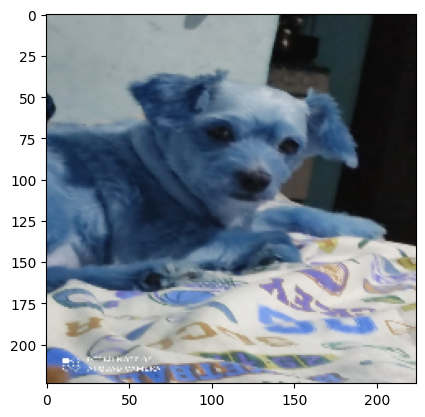

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[0.9803011]]
Predicted class is Dog


In [36]:
img = cv2.imread('/content/f9253974-9d63-408f-b5f0-878cad59669c.jpg')
plt.imshow(img) # Se muestra la imagen original.
plt.show()

resize = tf.image.resize(img, (224,224)) # Se muestra la imagen redimensionada.
plt.imshow(resize.numpy().astype(int))
plt.show()

yhat = model.predict(np.expand_dims(resize/255, 0))
print(yhat)

if yhat > 0.5:
    print(f'Predicted class is Dog')
else:
    print(f'Predicted class is Cat')

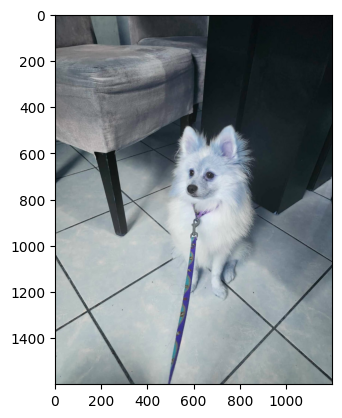

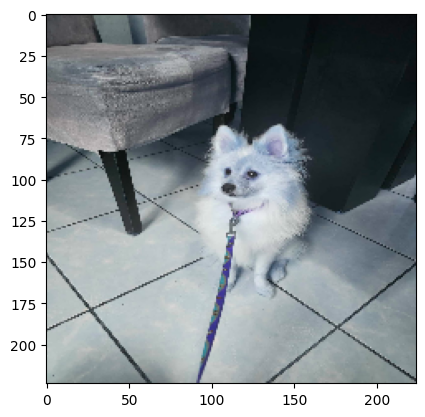

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.7288047]]
Predicted class is Dog


In [37]:
img = cv2.imread('/content/8538bc53-bb04-4d46-9ded-9dffe831b651.jpg')
plt.imshow(img) # Se muestra la imagen original.
plt.show()

resize = tf.image.resize(img, (224,224)) # Se muestra la imagen redimensionada.
plt.imshow(resize.numpy().astype(int))
plt.show()

yhat = model.predict(np.expand_dims(resize/255, 0))
print(yhat)

if yhat > 0.5:
    print(f'Predicted class is Dog')
else:
    print(f'Predicted class is Cat')

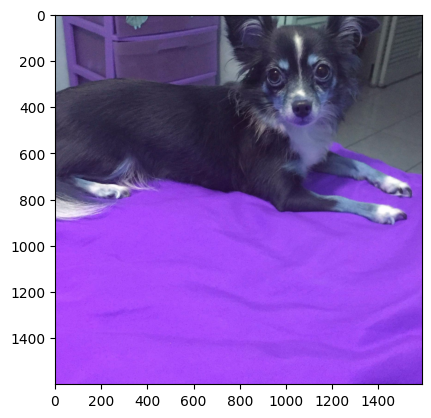

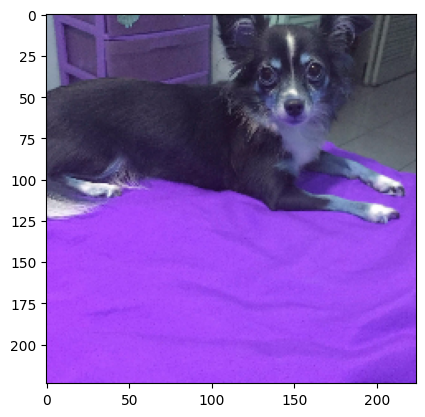

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[[0.65926015]]
Predicted class is Dog


In [38]:
img = cv2.imread('/content/514fd442-cc05-4292-9bd9-bc35365a5267.jpg')
plt.imshow(img)
plt.show() # Se muestra la imagen original.

resize = tf.image.resize(img, (224,224)) # Se muestra la imagen redimensionada.
plt.imshow(resize.numpy().astype(int))
plt.show()

yhat = model.predict(np.expand_dims(resize/255, 0))
print(yhat)

if yhat > 0.5:
    print(f'Predicted class is Dog')
else:
    print(f'Predicted class is Cat')

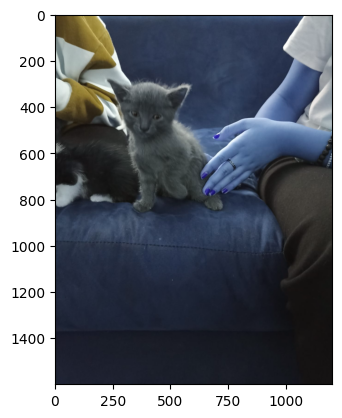

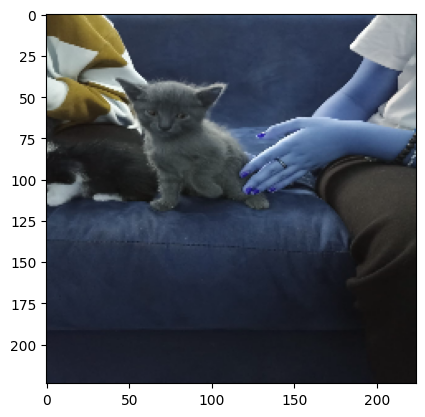

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[[0.00016611]]
Predicted class is Cat


In [39]:
img = cv2.imread('/content/741181fd-1314-4cf0-b0b4-805fa6ff05ae.jpg')
plt.imshow(img)
plt.show() # Se muestra la imagen original.

resize = tf.image.resize(img, (224,224)) # Se muestra la imagen redimensionada.
plt.imshow(resize.numpy().astype(int))
plt.show()

yhat = model.predict(np.expand_dims(resize/255, 0))
print(yhat)

if yhat > 0.5:
    print(f'Predicted class is Dog')
else:
    print(f'Predicted class is Cat')

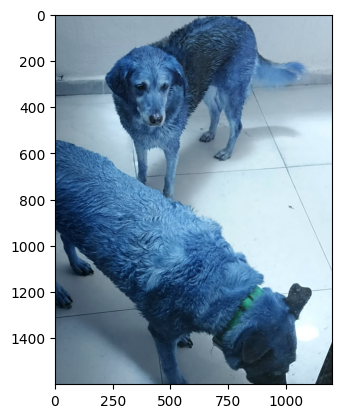

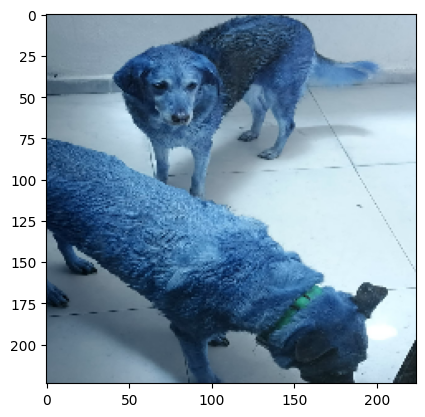

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[[0.856997]]
Predicted class is Dog


In [40]:
img = cv2.imread('/content/a23a0a75-45b8-4694-8929-e01a7af33ec1.jpg')
plt.imshow(img)
plt.show() # Se muestra la imagen original.

resize = tf.image.resize(img, (224,224)) # Se muestra la imagen redimensionada.
plt.imshow(resize.numpy().astype(int))
plt.show()

yhat = model.predict(np.expand_dims(resize/255, 0))
print(yhat)

if yhat > 0.5:
    print(f'Predicted class is Dog')
else:
    print(f'Predicted class is Cat')